# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Core Game Engine

In [2]:
def get_payoff_and_coop_final(p, q, b1, b2, c, eps, rule):
    """
    Calculates long-term average payoffs and cooperation rates.
    
    Args:
        p, q: Strategy vectors (4-element probabilities).
        b1, b2: Benefit values in State 1 and State 2.
        c: Cost of cooperation.
        eps: Error rate (noise).
        rule: 4-element list mapping action profiles [CC, CD, DC, DD] 
              to the next environment (0=State 1, 1=State 2).
    """
    # Apply noise to strategy execution probabilities
    p_eff = p * (1 - 2 * eps) + eps
    q_eff = q * (1 - 2 * eps) + eps
    
    # Initialize 8x8 Transition Matrix (States: 0-3 for Env 1, 4-7 for Env 2)
    M = np.zeros((8, 8))
    opp_idx = {0: 0, 1: 2, 2: 1, 3: 3} 
    
    for s in range(8):
        env = s // 4
        c1 = p_eff[s]
        # Determine opponent's move probability based on previous state
        c2 = q_eff[env * 4 + opp_idx[s % 4]]
        
        # Action profile probabilities: [CC, CD, DC, DD]
        probs = [c1 * c2, c1 * (1 - c2), (1 - c1) * c2, (1 - c1) * (1 - c2)]
        
        for act_idx, prob in enumerate(probs):
            # Determine next environment based strictly on the feedback rule
            next_env = rule[act_idx]  
            M[s, next_env * 4 + act_idx] = prob

    # Calculate stationary distribution via eigenvectors
    vals, vecs = np.linalg.eig(M.T)
    # Extract eigenvector corresponding to eigenvalue 1.0
    v = np.abs(vecs[:, np.isclose(vals, 1.0)].real[:, 0])
    v /= v.sum()
    
    # Define payoff vectors for Player 1 (p) and Player 2 (q)
    u1 = np.array([b1 - c, -c, b1, 0])
    u2 = np.array([b2 - c, -c, b2, 0])
    
    u1_m = np.array([b1 - c, b1, -c, 0])
    u2_m = np.array([b2 - c, b2, -c, 0])
    
    # Calculate expected payoffs
    pi_p = np.dot(v[:4], u1) + np.dot(v[4:], u2)
    pi_q = np.dot(v[:4], u1_m) + np.dot(v[4:], u2_m)
    
    # Calculate total cooperation rate (indices 0, 1 in Env 1; 4, 5 in Env 2)
    coop = v[0] + v[1] + v[4] + v[5]
    
    return pi_p, pi_q, coop

In [3]:
def get_fixation_probability(pi_m, pi_r, pi_mm, pi_rm, N, beta):
    """ 
    Calculates the probability that a single mutant fixes in a resident population.
    Uses the closed-form solution for the pairwise comparison process.
    """
    diffs = []
    for k in range(1, N):
        # Payoff of mutant (m) and resident (r) in a mixed population of size k
        f_m = ((k - 1) * pi_mm + (N - k) * pi_m) / (N - 1)
        f_r = (k * pi_rm + (N - k - 1) * pi_r) / (N - 1)
        diffs.append(f_r - f_m)
        
    exponent_sums = np.cumsum(beta * np.array(diffs))
    
    # Clip exponents to prevent numerical overflow/underflow
    return 1.0 / (1.0 + np.sum(np.exp(np.clip(exponent_sums, -100, 100))))

# Parameters and Strategies

In [4]:
# Simulation parameters
N = 100
beta = 1.0
mu = 1e-5
c = 1.0
b2 = 1.2
eps = 0.001

b1_values = np.linspace(1.0, 3.0, 21)

# Deterministic memory-1 strategies
strats = [
    np.array([(i >> j) & 1 for j in range(3, -1, -1)] * 2, dtype=float)
    for i in range(16)
]

idx_AllD = 0
idx_WSLS = 9
neutral_freq = 1.0 / 16.0

In [5]:
cases = [
    {'rule': [0,0,0,0], 'label': 'a: 2C,1C,0C'}, 
    {'rule': [0,0,0,1], 'label': 'b: 2C,1C'}, 
    {'rule': [0,1,1,1], 'label': 'c: 2C'}, 
    {'rule': [1,0,0,0], 'label': 'd: 1C,0C'},
    {'rule': [0,1,1,0], 'label': 'e: 2C,0C'},
    {'rule': [1,1,1,0], 'label': 'f: 0C'},
    {'rule': [1,0,0,1], 'label': 'g: 1C'},
    {'rule': [1,1,1,1], 'label': 'h: No S1'}
]

# Simulation and Plotting

Processing a: 2C,1C,0C...
Processing b: 2C,1C...
Processing c: 2C...
Processing d: 1C,0C...
Processing e: 2C,0C...
Processing f: 0C...
Processing g: 1C...
Processing h: No S1...


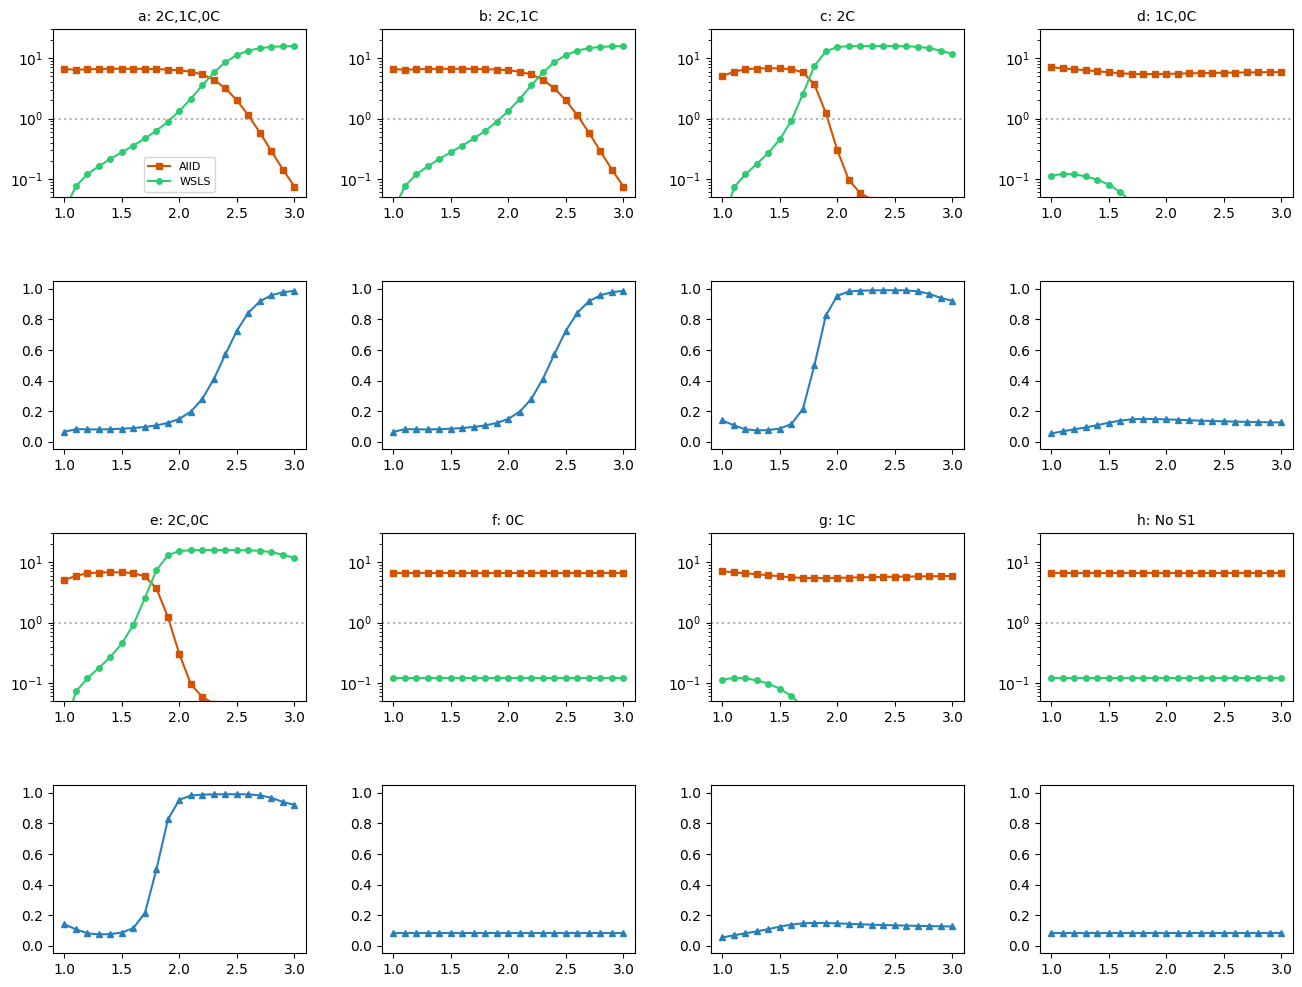

In [8]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

for idx, case in enumerate(cases):
    print(f"Processing {case['label']}...")
    all_d_rel, wsls_rel, coop_rates = [], [], []
    
    for b1 in b1_values:
        Fix = np.zeros((16, 16))
        for i in range(16): # Mutant
            for j in range(16): # Resident
                if i == j: continue
                pi_r, _, _ = get_payoff_and_coop_final(strats[j], strats[j], b1, b2, c, eps, case['rule'])
                pi_mm, _, _ = get_payoff_and_coop_final(strats[i], strats[i], b1, b2, c, eps, case['rule'])
                pi_rm, pi_m, _ = get_payoff_and_coop_final(strats[j], strats[i], b1, b2, c, eps, case['rule'])
                Fix[i, j] = get_fixation_probability(pi_m, pi_r, pi_mm, pi_rm, N, beta)
        
        T = (1 - mu) * Fix / 15.0 + mu / 15.0
        for j in range(16):
            T[j, j] = 1.0 - np.sum(T[:, j]) + T[j, j]
        
        vals, vecs = np.linalg.eig(T)
        abundance = np.abs(vecs[:, np.isclose(vals, 1.0)].real[:, 0])
        abundance /= abundance.sum()
        
        all_d_rel.append(abundance[idx_AllD] / neutral_freq)
        wsls_rel.append(abundance[idx_WSLS] / neutral_freq)
        
        avg_c = sum(abundance[k] * get_payoff_and_coop_final(strats[k], strats[k], b1, b2, c, eps, case['rule'])[2] for k in range(16))
        coop_rates.append(avg_c)

    # Plotting
    col = idx % 4
    row_ab, row_co = (0 if idx < 4 else 2), (1 if idx < 4 else 3)
    
    ax1 = axes[row_ab, col]
    ax1.plot(b1_values, all_d_rel, 's-', color='#D35400', label='AllD', ms=4)
    ax1.plot(b1_values, wsls_rel, 'o-', color='#2ECC71', label='WSLS', ms=4)
    ax1.set_yscale('log')
    ax1.set_ylim(0.05, 30)
    ax1.axhline(1.0, color='gray', linestyle=':', alpha=0.6)
    ax1.set_title(case['label'], fontsize=10)
    
    ax2 = axes[row_co, col]
    ax2.plot(b1_values, coop_rates, '^-', color='#2980B9', ms=4)
    ax2.set_ylim(-0.05, 1.05)

axes[0,0].legend(fontsize=8)
plt.show()